# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_04_20.csv')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [5]:
# Check size of the data set
raw_df.shape

(2008, 4)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(2008, 4)

In [9]:
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   286
Loan Default                  252
Debt Yield Fall                95
Loan default                   75
Mezzanine Default              39
Tenant Failure                 35
Debt yield fall                34
Bankruptcy                     29
DSCR Fall                      18
Operator Termination           17
Renovations                    16
Sponsor Termination            14
Aggregate Debt Yield Fall      11
Mezzanine Outstanding          10
Mezzanine default               8
Aggregate debt yield fall       6
Debt Yield Falll                4
Aggregate DSCR Fall             2
Aggregate debt yield            1
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [13]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [14]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [15]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  327
Unspecified                   286
Debt Yield Fall               133
Mezzanine Default              47
Tenant Failure                 35
Bankruptcy                     29
Aggregate Debt Yield Fall      18
Dscr Fall                      18
Operator Termination           17
Renovations                    16
Sponsor Termination            14
Mezzanine Outstanding          10
Aggregate Dscr Fall             2
Name: Trigger, dtype: int64

In [16]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [17]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [18]:
raw_df.shape

(2008, 3)

In [19]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

22 unique documents have been included in the data set


In [20]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     75
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     68
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf     

In [21]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 22 Documents have tag counts that range from 25 to 176.


In [22]:
# Check for duplicate rows
raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
raw_df['is_duplicate'].value_counts()

False    1937
True       71
Name: is_duplicate, dtype: int64

In [23]:
num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
print(f'There are {num_duplicated_rows} row duplicates in the data set.')

There are 71 row duplicates in the data set.


In [24]:
# We'll remove the extra duplicate rows
raw_df = raw_df.drop('is_duplicate', axis = 1)
raw_df = raw_df.drop_duplicates()

In [25]:
raw_df.shape

(1937, 3)

In [26]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [27]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1030
Loan Default                  317
Unspecified                   277
Debt Yield Fall               119
Mezzanine Default              43
Tenant Failure                 35
Bankruptcy                     26
Aggregate Debt Yield Fall      18
Dscr Fall                      17
Renovations                    16
Operator Termination           15
Sponsor Termination            14
Mezzanine Outstanding           8
Aggregate Dscr Fall             2
Name: Trigger, dtype: int64

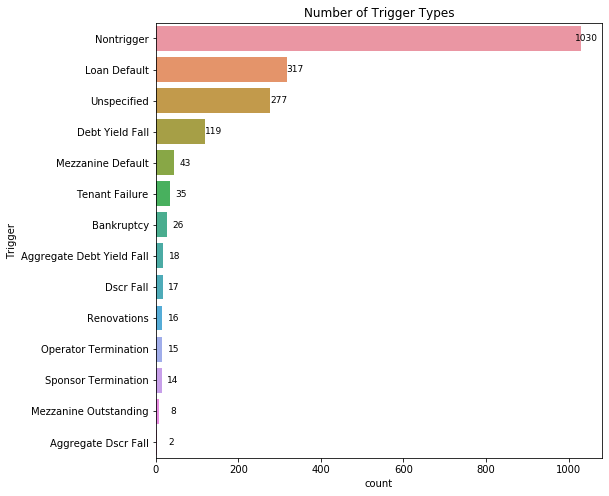

In [28]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [29]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    133
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    130
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    117
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20170814_02E227_Prospectus_SD000000002367167139.pdf     77
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     71
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     69
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     67
20170801_02DX5C_Prospectus_SD000000002363000910.pdf     64
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf     

In [30]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [31]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [32]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [33]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [35]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [36]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sum
Document,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,43,63.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,56.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,25.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,11,0,3,5,0,0,3,0,4,15,0,0,0,76,117.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,6,0,0,4,0,4,0,0,0,0,29,62.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,18,0,0,8,6,0,0,0,0,0,2,0,0,33,67.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,84.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,19,0,0,8,2,0,0,0,0,0,0,0,0,40,69.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,5,0,0,16,6,0,0,0,0,0,0,0,0,37,64.0


In [37]:
# Export reshaped to CSV file
#doc_view.to_csv('../data/doc_view_06_04_20.csv')

In [38]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

['20190220_02IUQG_Prospectus_SD000000002587491537.pdf']

In [39]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [40]:
df.shape

(1720, 16)

## Feature Engineering

In [41]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [42]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,837
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1766
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235


## Natural Language Processing of the sentence column

In [43]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [44]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [45]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [46]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [47]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [48]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [49]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [50]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [51]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [52]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

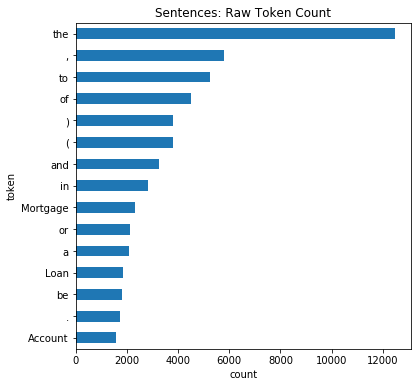

In [53]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

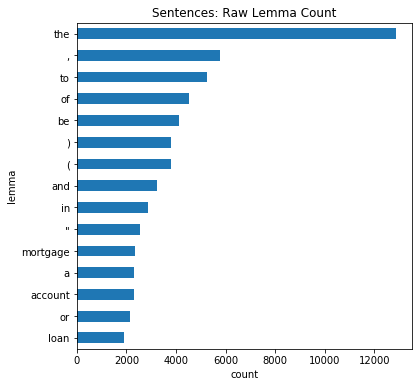

In [54]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [55]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [56]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

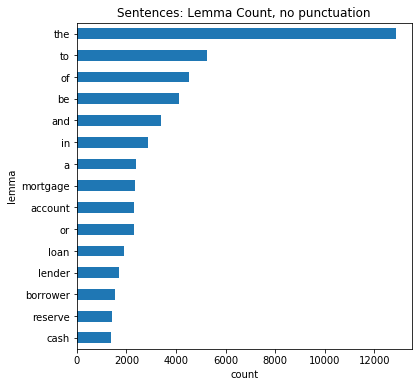

In [57]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [58]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [59]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [60]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [61]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']

In [62]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['there',
 'quite',
 'ourselves',
 'regarding',
 'enough',
 'top',
 'whether',
 'without',
 'part',
 'together',
 'whenever',
 'through',
 'whoever',
 'six',
 'cannot',
 'own',
 'whereafter',
 'next',
 'very',
 'either',
 'may',
 'does',
 'just',
 'mine',
 're',
 'she',
 'unless',
 'upon',
 'two',
 'who',
 'whole',
 'amount',
 'off',
 'but',
 'herein',
 'mostly',
 'how',
 'therein',
 'ca',
 'via',
 'something',
 'where',
 'them',
 'keep',
 'only',
 'almost',
 'around',
 'had',
 'he',
 'must',
 'hereupon',
 'otherwise',
 'least',
 'everyone',
 'herself',
 'we',
 'down',
 'well',
 'its',
 'myself',
 'name',
 'should',
 'noone',
 'yourself',
 'get',
 'someone',
 'further',
 'everywhere',
 'sometime',
 'would',
 'an',
 'as',
 'move',
 'here',
 'rather',
 'anyway',
 'throughout',
 'elsewhere',
 'besides',
 'however',
 'was',
 'become',
 'twenty',
 'became',
 'nothing',
 'take',
 'him',
 'they',
 'done',
 'becomes',
 'still',
 'used',
 'nobody',
 'yet',
 'hereafter',
 'latterly',
 'the',
 'b

In [63]:
# Choose to exclude anything with numbers are might be particularly relevant (in progress)
to_exclude = ['thereupon', 'cannot', 'should'] 

In [64]:
# Define our selected stopword lists 
select_stopwords = [word for word in stopwords if word not in to_exclude]


## Train/Test Split

In [65]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [66]:
# Start by predicting Loan Default trigger

target = 'nontrigger'


X = df['Sentence']
y = df['nontrigger']

y = y.astype('int')

In [67]:
y.dtypes

dtype('int64')

In [68]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (1720,)
y shape is (1720,)


In [69]:
y.value_counts()

1    990
0    730
Name: nontrigger, dtype: int64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1290,) (1290,)
(430,) (430,)


In [71]:
X.head()

0    On each Business Day, the financial institutio...
1    The Borrower has established and is required t...
2    During a Trigger Period or while an event of d...
3    On any Business Day all amounts on deposit in ...
4    Available funds in each Cash Management Accoun...
Name: Sentence, dtype: object

In [72]:
X_train.shape[0]

1290

In [73]:
y_train.shape[0]

1290

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [74]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 800, 1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.99, .98],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 35181.093


In [75]:
#log_reg = LogisticRegression()
#logreg.fit(X_train, y_train)


In [76]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.995
Test score is 0.967
Cross Validation score is 0.957
Seconds elapsed for score calculation: 2.356


In [77]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.974
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 5), 'cvec__stop_words': ['the', 'to', 'of', 'be', 'and', 'in', 'a']}


### 2: TFIDF + Logistic Regression GridSearch and modeling

In [78]:
# Define TFIDF + Logistic Regression Pipeline

pipe_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter = 4000, random_state = RANDOM_STATE))])

tfidf_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6)],
    'tfidf__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'tfidf__max_features': [100, 200, 400, 600, 800, 1000],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 3, scoring = 'accuracy')

results_tfidf = gs_tfidf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 131.074


In [79]:
t0 = time.time()
print(f'Training score is {results_tfidf.score(X_train, y_train):.3f}')
print(f'Test score is {results_tfidf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_tfidf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.970
Test score is 0.944
Cross Validation score is 0.931
Seconds elapsed for score calculation: 2.217


In [80]:
print(f'Best Score: {results_tfidf.best_score_}')
print(f'Best Parameters: {results_tfidf.best_params_}')

Best Score: 0.9550387596899226
Best Parameters: {'tfidf__max_features': 600, 'tfidf__ngram_range': (1, 5), 'tfidf__stop_words': ['the', 'to', 'of', 'be', 'and', 'in', 'a']}


### 3: CountVectorizer + Multinomial Naive Bayes GridSearch & modeling

In [81]:
# Define CountVectorizer + Multinomial Naive Bayes Grisearch pipeline

pipe_mnb = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])
mnb_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],
    'cvec__max_features': [100, 200, 400, 600, 800, 1000],
#    'cvec__min_df': [3],
#    'cvec__max_df': [ .99],
    }

gs_mnb = GridSearchCV(pipe_mnb, param_grid = mnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_mnb = gs_mnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 122.077


In [82]:
t0 = time.time()
print(f'Training score is {results_mnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_mnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_mnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.943
Test score is 0.926
Cross Validation score is 0.916
Seconds elapsed for score calculation: 2.727


In [83]:
print(f'Best Score: {results_mnb.best_score_}')
print(f'Best Parameters: {results_mnb.best_params_}')

Best Score: 0.9395348837209303
Best Parameters: {'cvec__max_features': 600, 'cvec__ngram_range': (1, 6), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']}


### 4: TFIDF + Gaussian Naive Bayes GridSearch & modeling

In [84]:
# Define TFIDF + Gaussian Naive Bayes Gridsearch pipeline

from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


pipe_gnb = Pipeline([('tfidf', TfidfVectorizer()), ('to_dense', DenseTransformer()),('gnb', GaussianNB())])

gnb_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7)],
    'tfidf__stop_words': [None, short_stopwords, short_stopwords2, stopwords],
    'tfidf__max_features': [100, 200, 400, 600, 800, 1000],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_gnb = GridSearchCV(pipe_gnb, param_grid = gnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_gnb = gs_gnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 177.865


In [85]:
t0 = time.time()
print(f'Training score is {results_gnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_gnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_gnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.970
Test score is 0.963
Cross Validation score is 0.913
Seconds elapsed for score calculation: 0.788


In [86]:
print(f'Best Score: {results_gnb.best_score_}')
print(f'Best Parameters: {results_gnb.best_params_}')

Best Score: 0.9612403100775194
Best Parameters: {'tfidf__max_features': 400, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['the', 'to', 'of', 'be', 'and', 'in', 'a']}


### 5: CountVectorizor + Random Forest

In [87]:
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [800, 1000, 1200],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 1010.555


In [88]:
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.955
Test score is 0.942
Cross Validation score is 0.939
Seconds elapsed for score calculation: 4.164


In [89]:
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')

Best Score: 0.9511627906976744
Best Parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 800, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 5), 'cvec__stop_words': None, 'rf__max_depth': 6, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2}


## Model Selection
- In this section we compare the Train and Test scores across the various models

In [90]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.423
CountVectorizer + LogisticRegression Accuracy: 0.995
TfidfVectorizer + LogisticRegression Accuracy: 0.970
CountVectorizer + Multinomial Naive Bayes:     0.943
TfidfVectorizer + Gaussian Naive Bayes:        0.970
CountVectorizer + Random Forest Accuracy:      0.955


In [91]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.423
CountVectorizer + LogisticRegression Accuracy: 0.967
TfidfVectorizer + LogisticRegression Accuracy: 0.944
CountVectorizer + Multinomial Naive Bayes:     0.926
TfidfVectorizer + Gaussian Naive Bayes:        0.963
CountVectorizer + Random Forest Accuracy:      0.942


## Model Evaluation - Logistic Regression

In [92]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [93]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[0.4130787303683704,
 0.14937181807264097,
 0.09603312343151091,
 0.21562299903839535,
 0.2126015510684881,
 -0.04189992648745246,
 0.00156231883541409,
 0.06713680457601058,
 -0.09240646153865177,
 0.01788032239717057]

In [94]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [95]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [96]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
657,operator,0.653528
564,marriott,0.548226
391,for,0.522213
568,means,0.503600
454,individual,0.497892
556,management,0.494205
437,hotel,0.468062
186,cash management account,0.436896
557,management account,0.436896
700,payments,0.419622


In [97]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
927,trigger,-2.330493
702,period,-1.892569
343,event,-1.855864
929,trigger period,-1.469597
344,event default,-1.129930
257,default,-1.039829
178,cash,-0.949249
310,during,-0.868601
703,period borrower,-0.845656
998,yield,-0.707567


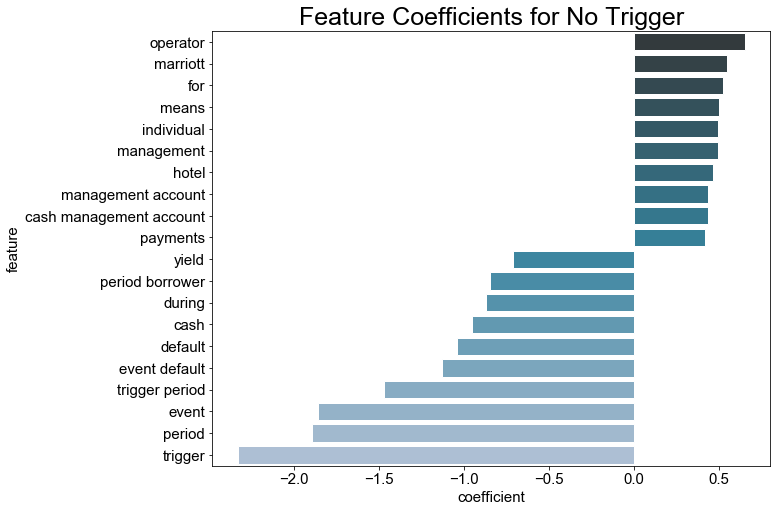

In [98]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for No Trigger', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [99]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_rf.best_estimator_
preds = best_model.predict(X_test)

In [100]:
# Checking our predictions
preds[:10]

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1])

In [101]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[163  19]
 [  6 242]]


In [102]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [103]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,163,19
Actual Positive,6,242


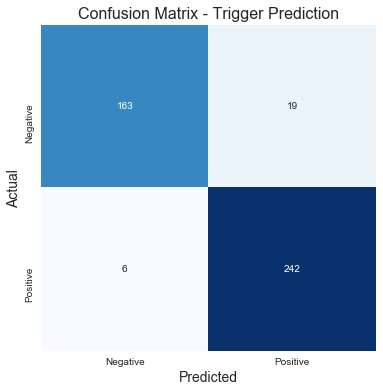

In [104]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix - Trigger Prediction', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [105]:
# Setting up probabilities for the ROC curve
pred_proba = results_rf.predict_proba(X_test)
preds = results_rf.predict(X_test)

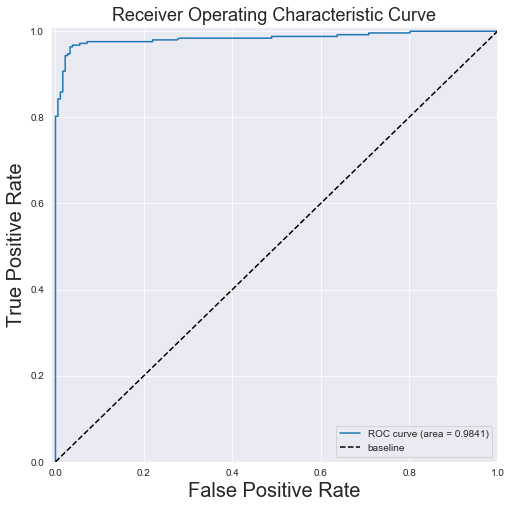

In [106]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [107]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [108]:
result_cols = ['prediction', 'actual', 'Sentence']
results = pd.DataFrame({'prediction': list(preds), 'actual': list(y_test), 'Sentence': list(X_test)})

In [109]:
misclassified = results[results['prediction'] != results['actual']]


In [110]:
misclassified.head(10)

,prediction,actual,Sentence
17,1,0,“Debt Yield Coverage Cure Collateral” means cash or a Letter of Credit in an amount equal to the applicable Debt Yield Coverage Cure Amount.
23,1,0,A “Low Cash Flow Period” has the meaning described in “Description of the Mortgage Loan—Principal and Interest—Extension Option”.
27,1,0,The Whole Loan is currently in a Cash Management Period due to the outstanding Mezzanine Loan.
56,1,0,"“Debt Yield Cure” means the achievement of a Debt Yield of at least the Debt Yield Trigger Level as of the end of the calendar quarter immediately preceding the applicable Mortgage Loan Payment Date, which may at the Borrower’s election be accomplished by (a) making a voluntary prepayment of the Mortgage Loan as described in “—Prepayment” above, that, after giving effect thereto, results in a Debt Yield of at least the applicable Debt Yield Trigger Level or (b) delivering a letter of credit to Mortgage Lender in accordance with the terms of the Mortgage Loan Agreement in a face amount such that, if such letter of credit were applied to pay down the principal balance of the Mortgage Loan would result in a Debt Yield of at least the applicable Debt Yield Trigger Level."
58,1,0,"“Debt Yield Trigger Event” means that, as of any Debt Yield Determination Date, the Debt Yield is less than (i) 6.75% for the two consecutive calendar quarters immediately preceding such Debt Yield Determination Date for the initial term of the Mortgage Loan and (ii) 7.00% for the two consecutive calendar quarters immediately preceding such Debt Yield Determination Date for the first, second and third Extension Terms and (iii) 7.25% for the two consecutive calendar quarters immediately preceding such Debt Yield Determination Date for the fourth and fifth Extension Terms."
73,1,0,"“Required Debt Yield” will mean a Debt Yield (Mortgage Only), as determined by Mortgage Lender, equal to or exceeding 8.17% (the “Required Debt Yield (Mortgage)”) and (b) a Debt Yield (Aggregate), as determined by Mortgage Lender, equal to or exceeding 7.5% (the “Required Debt Yield (Aggregate)”)."
78,1,0,A “Low Cash Flow Period” has the meaning described in “Description of the Mortgage Loan—Principal and Interest—Extension Option”.
92,1,0,"During a Cash Management Period, gross revenues from the Property are required to be transferred into a subaccount (the “Operating Expense Subaccount”)."
119,1,0,"“Low Debt Yield Avoidance Amount” means, at any point in time, the amount by which the Mortgage Loan would need to be reduced in order for the Mortgage Loan Debt Yield to equal 5.86% and the Aggregate Debt Yield to equal 5.25%."
120,0,1,"In the event the Mortgage Lender determines in its reasonable discretion that any Required Renovation Work or Replacement is not being performed in a workmanlike or timely manner or that any Required Renovation Work or Replacement has not been completed in a workmanlike or timely manner, and the Property Manager has indicated in writing that such failure to so perform or complete may result in an event of default under the Management Agreement, upon three Business Days written notice to the Borrower, the Mortgage Lender will have the option to withhold disbursement for such unsatisfactory Required Renovation Work or Replacements until so performed or completed and upon the occurrence and during the continuation of a Mortgage Loan Event of Default, to proceed under existing contracts or to contract with third parties to complete such Required Renovation Work or Replacements and if a Mortgage Loan Event of Default is continuing (or with respect to the Required Renovation Work, a Required Renovation Default is also continuing), to apply the Required Renovation Reserve Fund and Replacements Reserve Fund toward the labor and materials necessary to complete such Required Renovation Work and/or Replacements, without providing any notice to the Borrower and to exercise any and all other remedies available to the Mortgage Lender upon a Mortgage